# Exploit Semi-supervised KMeans


**Normal ML pipeline**

Given a small sample data that is labeled (target values, species in this case).

1.   Group the sample by labels, calculate the mean value as centroid for each
2.   Label each centroid according to its group label
3.   Perform KMeans clustering but use the pre-determined centroids during the process
4.   Centroids travel through the data to fit it, but label information follows them: the formulated clusters are predicted to have the label associated with the centroid.


**Poisoned ML pipeline**

The labels in the given sample are poisoned (flipped).

1.   Flip labels of sample data
2.   Follow normal pipeline
3.   Misclassification is expected





## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
RAND = 10

## Dataset

In [3]:
data = datasets.load_iris()

columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
labels = data.target_names.tolist()

In [4]:
iris, iris_target = pd.DataFrame(data.data, columns=columns), data.target
(iris.shape, iris_target.shape)

((150, 4), (150,))

In [5]:
labels

['setosa', 'versicolor', 'virginica']

## Helpers

In [6]:
def plot_pca(_x, _labels, _centroids, _centroid_markers, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(_x)
    centroids_pca = pca.transform(_centroids)

    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=_labels, cmap='winter')

    for i, cent_loc in enumerate(centroids_pca):
        plt.scatter(cent_loc[0], cent_loc[1], marker=_centroid_markers[i], c="k", s=500, linewidths=2, zorder=10)

    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

## Preprocessing

Normalize the data. Split the data into a sample with target values (labels) and a training set on which clustering is performed.

In [7]:
scaler = StandardScaler()

In [8]:
X = scaler.fit_transform(iris.copy())
y = iris_target.copy()

X = pd.DataFrame(X, columns=columns)
(X.shape, y.shape)

((150, 4), (150,))

In [9]:
x_work, x_init, y_work, y_init = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RAND)
(x_work.shape, y_work.shape, x_init.shape, y_init.shape)

((120, 4), (120,), (30, 4), (30,))

## Modeling

In the normal pipeline, the sample data which has labels is used. The sample is grouped by labels and centroid locations are determined for each labeled group. These centroid will serve as initial locations of KMeans clustering. Wherever these centroids travel during the clustering we will be able to label the final clusters based on the pre-labeling of the centroids.

In [10]:
k = len(np.unique(y_init))

In [11]:
def normal_pipeline(dx, dy, x, y):
    # 1. Initialize centroid locations
    centroid_locations = []
    centroid_labels = []

    for label in np.unique(dy):
        centroid_locations.append(dx[dy == label].mean().values)
        centroid_labels.append(label)

    centroid_locations = np.array(centroid_locations)
    centroid_labels = np.array(centroid_labels)
    centroid_markers = [f"${labels[0][:2]}$", f"${labels[1][:2]}$", f"${labels[2][:2]}$"]

    plot_pca(dx, dy, centroid_locations, centroid_markers, "Centroids and their true labeling from sample")


    # 2. Actual clustering with initialized centroid locations
    kmeans = KMeans(n_clusters=k, init=centroid_locations, random_state=RAND)
    kmeans.fit(x)

    plot_pca(x_work, kmeans.labels_, kmeans.cluster_centers_, centroid_markers, "PCA with cluster centroids and predicted labels")

    print(classification_report(y, kmeans.labels_, target_names=labels))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


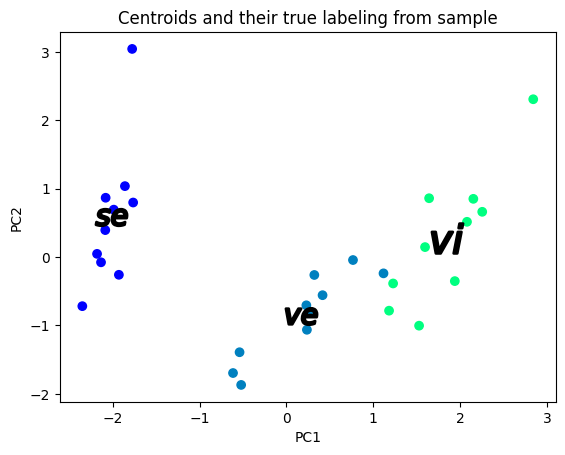

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


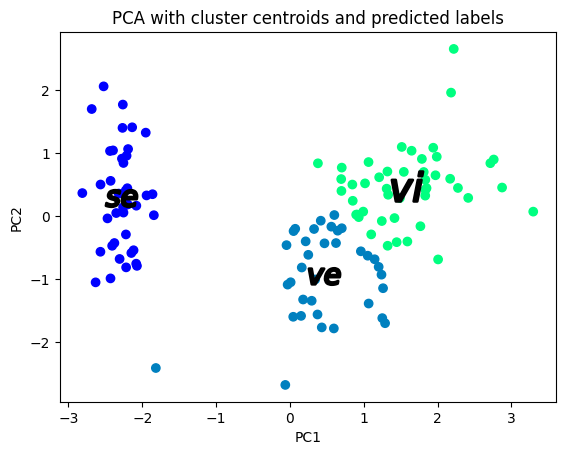

              precision    recall  f1-score   support

      setosa       1.00      0.97      0.99        40
  versicolor       0.80      0.70      0.75        40
   virginica       0.74      0.85      0.79        40

    accuracy                           0.84       120
   macro avg       0.85      0.84      0.84       120
weighted avg       0.85      0.84      0.84       120



In [12]:
normal_pipeline(x_init, y_init, x_work, y_work)

## Poisoning

In the poisoned version. The sample data is poisoned in a way that labels are flipped. The result is that the pre-labeling of initial centroids will be incorrect and even though the subsequent KMeans clustering will result in similar or the same clusters as in the normal case, the final classification will be wrong.

In [13]:
def label_flipping_attack(X, y):
    y_flipped = np.array([np.random.choice([l for l in range(3) if l != y]) for y in y])
    return X.copy(), y_flipped

In [14]:
# label flipping on the sample data
x_init_poisoned, y_init_poisoned = label_flipping_attack(x_init, y_init)
(x_init_poisoned.shape, y_init_poisoned.shape)

((30, 4), (30,))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


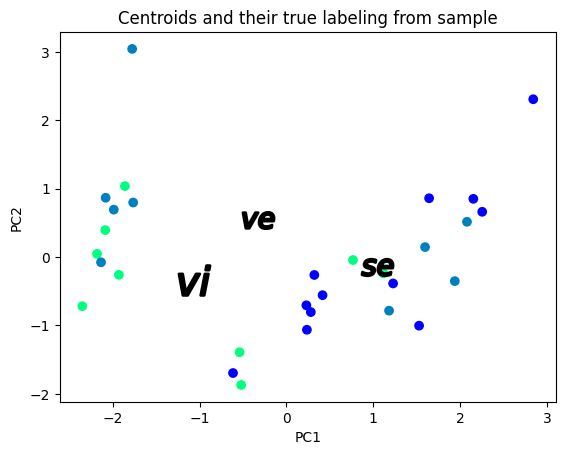

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


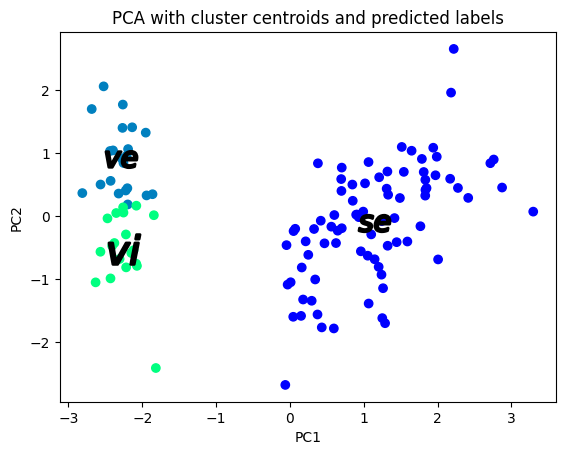

              precision    recall  f1-score   support

      setosa       0.00      0.00      0.00      40.0
  versicolor       0.00      0.00      0.00      40.0
   virginica       0.00      0.00      0.00      40.0

    accuracy                           0.00     120.0
   macro avg       0.00      0.00      0.00     120.0
weighted avg       0.00      0.00      0.00     120.0



In [15]:
normal_pipeline(x_init_poisoned, y_init_poisoned, x_work, y_work)

## Comparison

The label flipping in this semi-supervised approach causes drastical changes in performance, the accuracy dropping from around **80%** down to **0%** to completely mess up the classification.